# Zipfile Extraction

In [1]:
from google.colab import drive

In [6]:
drive.mount('/content/drive/')
path = '/content/drive/My Drive/ML Project/Datasets/'
!ls /content/drive/My\ Drive/ML\ Project/Datasets/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
annotations_dynamic.csv  audio_static.csv  lyrics_linguistic.csv
annotations_static.csv	 eda_dynamic.csv   lyrics_tfidf.csv
audio_dynamic.csv	 eda_static.csv


# Feature Visualizations

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
axd = pd.read_csv(path+'audio_dynamic.csv')
exd = pd.read_csv(path+'eda_dynamic.csv')
exd = exd.groupby(by=['musicId', 'frameTime'], as_index=False).mean()
yd = pd.read_csv(path+'annotations_dynamic.csv')

## CSV Description and Visualization

In [39]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

In [69]:
lyrics_tfidf = pd.read_csv('/content/drive/MyDrive/ML Project/Datasets/lyrics_tfidf.csv')
lyrics_linguistic = pd.read_csv('/content/drive/MyDrive/ML Project/Datasets/lyrics_linguistic.csv')
audio_static = pd.read_csv('/content/drive/MyDrive/ML Project/Datasets/audio_static.csv')
eda_static = pd.read_csv('/content/drive/MyDrive/ML Project/Datasets/eda_static.csv')
print(audio_static.shape, eda_static.shape, lyrics_tfidf.shape, lyrics_linguistic.shape)
eda_dataset = eda_static.groupby(by=['musicId'], as_index=False).mean()

(794, 6374) (7689, 130) (623, 577) (603, 24)


In [37]:
print(axd.shape, exd.shape, yd.shape)

(59755, 262) (36434, 50) (36434, 4)


In [49]:
X = pd.merge(axd,exd,on=['musicId','frameTime'])
id = X['musicId']
X.drop('musicId', axis=1, inplace=True)
X.drop('frameTime', axis=1, inplace=True)
print(X.shape)

(36434, 308)


In [56]:
#Arousal
estimators = [('RF', RandomForestRegressor(max_depth=5, n_estimators=50, max_features=2)),
              ('AB', AdaBoostRegressor(random_state=2, n_estimators=50))]

train_songs, test_songs = train_test_split(pd.unique(id),test_size=0.1,random_state=0)
X_train = X[[id[i] in train_songs for i in range(X.shape[0])]]
X_test = X[[id[i] in test_songs for i in range(X.shape[0])]]
y_train = yd[[id[i] in train_songs for i in range(yd.shape[0])]]
y_test = yd[[id[i] in test_songs for i in range(yd.shape[0])]]

In [61]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
values = pd.DataFrame(data=y_test)

(32896, 308) (32896, 4)
(3538, 308) (3538, 4)


In [63]:
stack_reg = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(normalize=True))
stack_model_Ar = stack_reg.fit(X_train, y_train['Arousal(mean)'])
y_pred = stack_model_Ar.predict(X_test)
rmse_score = mean_squared_error(y_test['Arousal(mean)'], y_pred, squared=False)
mae_score = mean_absolute_error(y_test['Arousal(mean)'], y_pred)
values['stack_ar'] = y_pred
print("Stacking Regressor ::: RMSE: {} and MAE: {}".format(rmse_score, mae_score))

Stacking Regressor ::: RMSE: 0.1229054944813655 and MAE: 0.09737938715036448


In [65]:
stack_reg = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(normalize=True))
stack_model_Va = stack_reg.fit(X_train, y_train['Valence(mean)'])
y_pred = stack_model_Va.predict(X_test)
rmse_score = mean_squared_error(y_test['Valence(mean)'], y_pred, squared=False)
mae_score = mean_absolute_error(y_test['Valence(mean)'], y_pred)
values['stack_va'] = y_pred
print("Stacking Regressor ::: RMSE: {} and MAE: {}".format(rmse_score, mae_score))

Stacking Regressor ::: RMSE: 0.13869215180669817 and MAE: 0.11267598180861994


In [74]:
values = values.groupby(by='musicId', as_index=False).mean()

,musicId,frameTime,Arousal(mean),Valence(mean),stack_ar,vote_ar,stack_va
0,4,21.75,0.293052,0.294274,0.419259,0.488848,0.439767
1,12,21.25,0.707445,0.608949,0.568554,0.576571,0.582083
2,18,33.75,0.818142,0.849818,0.639560,0.609384,0.627459
3,34,25.75,0.688296,0.842981,0.693616,0.628657,0.654516
4,39,29.75,0.868471,0.650493,0.803019,0.668956,0.717892


In [67]:
pickle.dump(stack_model_Ar, open('Stack_Arousal.sav', 'wb'))
pickle.dump(stack_model_Va, open('Stack_Valence.sav', 'wb'))
pickle.dump(vote_model_Ar, open('Vote_Arousal.sav', 'wb'))
pickle.dump(vote_model_Va, open('Vote_Valence.sav', 'wb'))

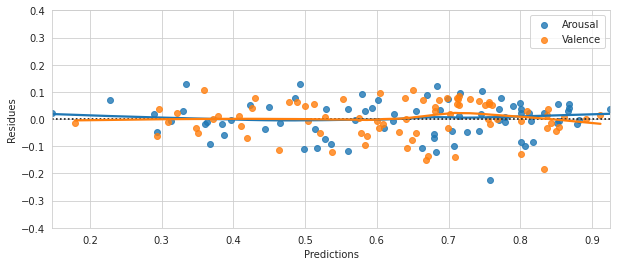

In [75]:
sns.set_style("whitegrid")
preds_As = values['Arousal(mean)']
preds_Vs = values['Valence(mean)']
plt.figure(figsize=(10,4))
sns.residplot(x=preds_As, y=values['stack_ar'], lowess=True, label='Arousal')
sns.residplot(x=preds_Vs, y=values['stack_va'], lowess=True, label='Valence')
plt.xlabel('Predictions')
plt.ylabel('Residues')
plt.legend()
plt.yticks(ticks=[-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4])
plt.show()

<Figure size 720x288 with 0 Axes>

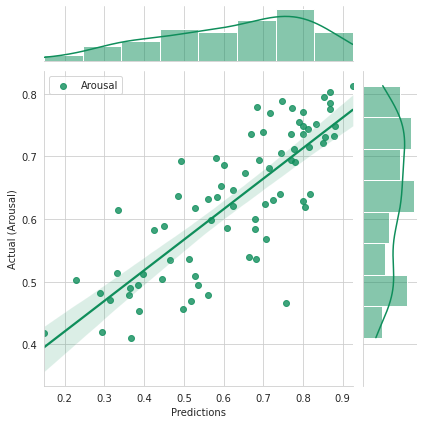

In [80]:
plt.figure(figsize=(10,4))
sns.jointplot(x=preds_As, y=values['stack_ar'], label='Arousal', kind='reg', color='#0F8E5B')
plt.xlabel('Predictions')
plt.ylabel('Actual (Arousal)')
plt.legend()
#plt.xticks(ticks=np.arange(np.min(preds), np.max(preds), 6))
#plt.yticks(ticks=[-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4])
plt.show()

<Figure size 720x288 with 0 Axes>

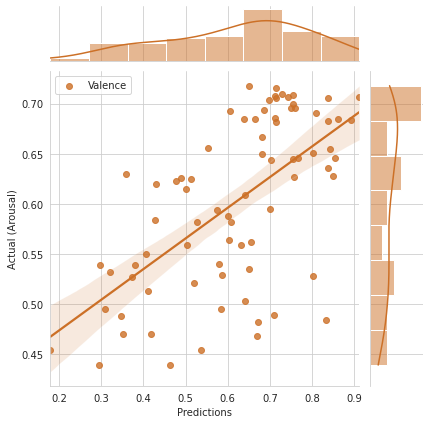

In [82]:
plt.figure(figsize=(10,4))
sns.jointplot(x=preds_Vs, y=values['stack_va'], label='Valence', kind='reg', color='#CC7027')
plt.xlabel('Predictions')
plt.ylabel('Actual (Arousal)')
plt.legend()
#plt.xticks(ticks=np.arange(np.min(preds), np.max(preds), 6))
#plt.yticks(ticks=[-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4])
plt.show()